In [8]:
import mediapipe as mp
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import sys
import cv2
import json

sys.path.append('/home/dasec-notebook/Thesis/skin_tone_estimation')

from utils import sclera_segmentation_utils 
from utils import color_correction_utils


sys.path.append('/home/dasec-notebook/Thesis/sclera-segmentation/src')

import sclera # NOTE: This is the custom module for sclera segmentation taken from https://github.com/wkabbani/sclera-segmentation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
image_path_file = "../image_paths/test_images.txt" 
degub_directory = "debug_images"

# Load the image paths
with open(image_path_file, 'r') as f:
    image_paths = f.readlines()


In [20]:

# Generate the face mesh for images in the txt file

mp_face_mesh = mp.solutions.face_mesh


for image_path in image_paths:
    image_path = image_path.strip()
    # print(image_path)

    debug_path = f"{degub_directory}/{image_path.split('/')[-1]}"
    print(debug_path)
    l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path, debug_path=debug_path)

    if l_locations and r_locations:
        l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)

    print(len(l_values))
    print(len(r_values))




debug_images/DSC_0538.JPG
136
109
debug_images/DSC_0059.JPG
139
115
debug_images/DSC_0825.JPG
141
125
debug_images/DSC_0222.JPG


I0000 00:00:1733310041.837347   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310041.840599   23926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310041.851035   23921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310041.870274   23923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310041.911434   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310041.914434   23933 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310041.919957   23927 inference_feedback_manager.cc:114] Feedback manager re

118
80
debug_images/DSC_1717.JPG


W0000 00:00:1733310042.054233   23943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310042.092496   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310042.093569   23954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310042.099155   23949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310042.125068   23951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310042.164131   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310042.167026   23961 gl_context.cc:357] GL version: 3.2 

127
135
debug_images/DSC_1688.JPG
119
143
debug_images/DSC_0511.JPG
129
123
debug_images/DSC_1091.JPG


W0000 00:00:1733310042.259019   23963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310042.283376   23965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310042.339129   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310042.340240   23975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310042.344375   23970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310042.365416   23972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


125
111
debug_images/DSC_0168.JPG
119
122
debug_images/DSC_0102.JPG
163
118
debug_images/DSC_0101.JPG


I0000 00:00:1733310042.504750   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310042.506119   23989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310042.509876   23983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310042.528836   23986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310042.582416   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310042.584512   23996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310042.587198   23990 inference_feedback_manager.cc:114] Feedback manager re

175
156
debug_images/DSC_1299.JPG
140
108
debug_images/DSC_0858.JPG


I0000 00:00:1733310042.766581   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310042.776967   24010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310042.792688   24005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310042.849681   24004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


153
151
debug_images/DSC_0934.JPG


I0000 00:00:1733310043.014010   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.018259   24017 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310043.022261   24013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310043.091720   24014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310043.227233   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.237566   24024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)


82
94
debug_images/DSC_1202.JPG
32
48
debug_images/DSC_1934.JPG


W0000 00:00:1733310043.253874   24021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310043.282288   24019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310043.363742   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.367202   24032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310043.374178   24027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310043.396636   24028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


4
5
debug_images/DSC_4309.JPG
4
5
debug_images/DSC_1754.JPG
4
4
debug_images/DSC_0893.JPG
11
7
debug_images/DSC_1431.JPG


W0000 00:00:1733310043.456812   24033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310043.495457   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.497786   24046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310043.503616   24041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310043.520782   24040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310043.549641   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.550729   24053 gl_context.cc:357] GL version: 3.2 

7
6
debug_images/DSC_2736.JPG
9
8
debug_images/DSC_0704.JPG
4
4
debug_images/DSC_2619.JPG
6
7
debug_images/DSC_1910.JPG


I0000 00:00:1733310043.663262   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.666053   24067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310043.674339   24061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310043.693121   24064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310043.737202   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310043.738773   24074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310043.743112   24069 inference_feedback_manager.cc:114] Feedback manager re

3
2
debug_images/DSC_0692.JPG
6
2
debug_images/DSC_1656.JPG
7
4
debug_images/DSC_1372.JPG
5
8
debug_images/DSC_4549.JPG


I0000 00:00:1733310044.082622   24109 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310044.086933   24104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310044.105370   24103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310044.138883   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310044.140043   24116 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310044.144334   24112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310

9
4
debug_images/DSC_1665.JPG
13
5
debug_images/DSC_3771.JPG
13
5
debug_images/DSC_4301.JPG
9
7
debug_images/DSC_3763.JPG


W0000 00:00:1733310044.286163   24124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310044.323132   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310044.324145   24137 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310044.327553   24132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310044.348524   24132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310044.388684   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310044.389707   24144 gl_context.cc:357] GL version: 3.2 

9
7
debug_images/DSC_2992.JPG
8
8
debug_images/PXL_20220922_182708946.jpg


I0000 00:00:1733310044.519381   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310044.520427   24158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310044.523942   24154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310044.545063   24155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


7420
10007
debug_images/PXL_20220922_182647374.jpg


I0000 00:00:1733310045.212775   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310045.213972   24171 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310045.217584   24166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310045.226928   24167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


3920
4301
debug_images/PXL_20220922_173547366.jpg


I0000 00:00:1733310045.582159   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310045.583661   24178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310045.591752   24173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310045.611304   24172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


3263
5380
debug_images/PXL_20220922_173604730.jpg


I0000 00:00:1733310045.938287   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310045.939931   24185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310045.950186   24181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310045.970395   24181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


3197
2918
debug_images/PXL_20220922_135802547.jpg


I0000 00:00:1733310046.304039   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310046.306093   24192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310046.309803   24188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310046.328974   24186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


4121
3210
debug_images/PXL_20220922_135941951.jpg


I0000 00:00:1733310046.718601   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310046.720009   24199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310046.723274   24194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310046.747806   24193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1987
1861
debug_images/PXL_20220922_194557410.jpg


I0000 00:00:1733310047.002312   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310047.005251   24206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310047.013741   24203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310047.040180   24201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1515
2801
debug_images/PXL_20220922_163052549.jpg


I0000 00:00:1733310047.317006   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310047.318238   24213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310047.321550   24209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310047.347317   24208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1884
2540
debug_images/PXL_20220922_163045525.jpg


I0000 00:00:1733310047.778768   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310047.784209   24220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310047.788542   24214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310047.829785   24215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


5094
4852
debug_images/PXL_20220922_175732630.jpg
2309
4436
debug_images/PXL_20220922_180402602.jpg


I0000 00:00:1733310048.516916   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310048.518085   24228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310048.520974   24224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310048.536874   24223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310048.718647   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310048.719728   24235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310048.722790   24230 inference_feedback_manager.cc:114] Feedback manager re

813
1164
debug_images/PXL_20220922_174104129.jpg
3385
4260
debug_images/PXL_20220922_174114139.jpg
1257
1927
debug_images/PXL_20220922_141810468.PORTRAIT.jpg


I0000 00:00:1733310049.083498   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310049.084631   24249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310049.087392   24244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310049.099059   24246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310049.242585   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310049.243598   24256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310049.247322   24250 inference_feedback_manager.cc:114] Feedback manager re

1384
1149
debug_images/PXL_20220922_141826372.PORTRAIT.jpg


I0000 00:00:1733310049.436380   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310049.437370   24263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310049.442189   24258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310049.462037   24257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


2010
2485
debug_images/PXL_20220922_162054939.jpg


I0000 00:00:1733310049.745702   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310049.748495   24270 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310049.752517   24267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310049.769293   24264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


2155
1677
debug_images/PXL_20220922_162046872.jpg


I0000 00:00:1733310050.041363   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310050.042663   24277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310050.046890   24272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310050.058398   24272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


3845
3252
debug_images/PXL_20220922_200152527.jpg


I0000 00:00:1733310050.344602   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310050.346951   24284 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310050.353851   24280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310050.366989   24278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


5190
5075
debug_images/PXL_20220922_195656401.jpg


I0000 00:00:1733310050.761831   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310050.763779   24291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310050.769339   24288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310050.784928   24285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


4552
4252


Plot example of one person with a masked image

mask shape (558, 501, 3)


I0000 00:00:1733310051.126255   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310051.127318   24298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310051.130990   24295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310051.155451   24295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


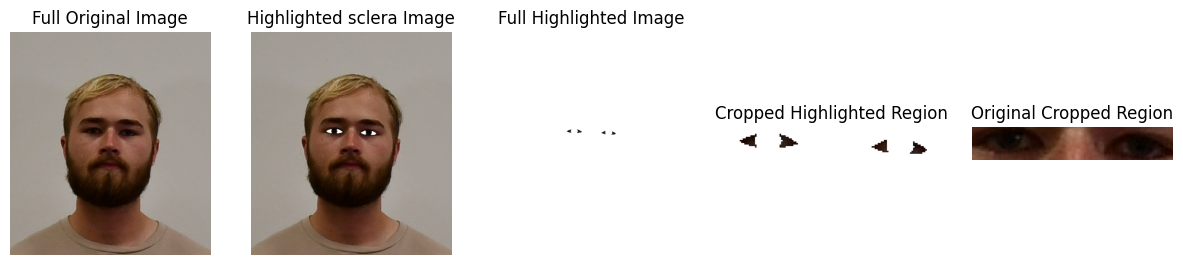

In [21]:
mp_face_mesh = mp.solutions.face_mesh

debug_path = "test_image2.jpg"
image_path = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00067/DSC_0593.JPG"

l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path, debug_path=debug_path)

if l_locations and r_locations:
    l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)

# print(l_locations)
# print(r_locations)

# print(l_values)
# print(r_values)

# print(l_values.shape)
# print(r_values.shape)

# Plot the segmentation

image = Image.open(image_path)
image = np.array(image)  
mask = np.zeros(image.shape, dtype=bool)

for loc in l_locations + r_locations:
    x, y = loc
    mask[y, x] = True 

print("mask shape", mask.shape)


highlighted_image = image.copy()
highlighted_image[~mask] = 255 # NOTE: This is the color for the mask pixels

# Show the image with the sclera pixels highlighted
# plt.imshow(highlighted_image)
# plt.axis('off')  # Hide axis for better visualization
# plt.show()

# Save the image with the sclera pixels highlighted
highlighted_image = Image.fromarray(highlighted_image)
highlighted_image.save('highlighted_sclera2.jpg')


# Plot a small region of the sclera

sclera_coords = np.column_stack(np.where(mask[..., 0])) 

y_min, x_min = sclera_coords.min(axis=0)
y_max, x_max = sclera_coords.max(axis=0)

# Add a margin to the bounding box
margin = 5  
y_min = max(y_min - margin, 0)
x_min = max(x_min - margin, 0)
y_max = min(y_max + margin, image.shape[0])
x_max = min(x_max + margin, image.shape[1])


if isinstance(highlighted_image, Image.Image):
    highlighted_image = np.array(highlighted_image)

cropped_region = highlighted_image[y_min:y_max, x_min:x_max]
original_cropped_region = image[y_min:y_max, x_min:x_max]

# Save the cropped region
# cropped_region_pil = Image.fromarray(cropped_region)
# cropped_region_pil.save('highlighted_sclera_cropped.jpg')

# Display the images for visualization
plt.figure(figsize=(15, 7))

plt.subplot(1, 5, 1)
plt.title("Full Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title("Highlighted sclera Image")
debug_image = Image.open(debug_path)
debug_image = np.array(debug_image)
plt.imshow(debug_image)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title("Full Highlighted Image")
plt.imshow(highlighted_image)
plt.axis('off')


plt.subplot(1, 5, 4)
plt.title("Cropped Highlighted Region")
plt.imshow(cropped_region)
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title("Original Cropped Region")
plt.imshow(original_cropped_region)
plt.axis('off')

plt.show()

# Visualize the average sclera color for each person in the xyY color space

Based on the original images

I0000 00:00:1733310051.721694   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310051.722741   24308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310051.725572   24303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310051.740582   24302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733310051.789684   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310051.790805   24315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310051.794816   24310 inference_feedback_manager.cc:114] Feedback manager re

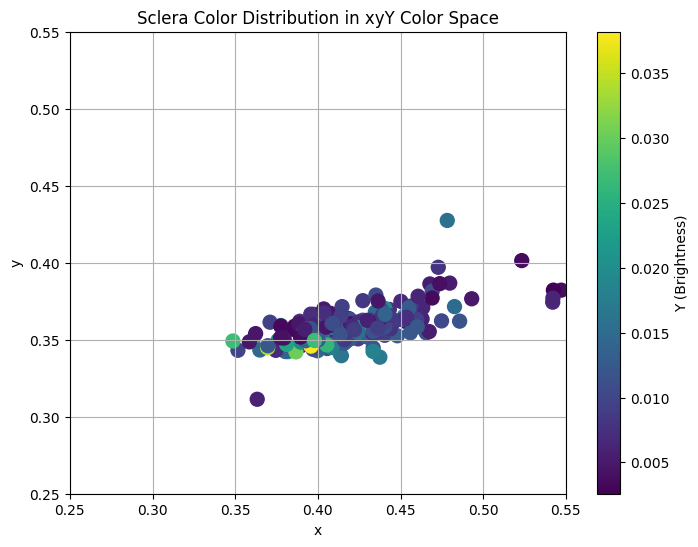

In [22]:


image_paths_txt = "/home/dasec-notebook/Thesis/skin_tone_estimation/image_paths/indoor.txt"
image_paths = open(image_paths_txt, 'r').readlines()

debug_directory = None
person_xyY = []  

for image_path in image_paths:
    image_path = image_path.strip()
    debug_path = f"{debug_directory}/{image_path.split('/')[-1]}"
    
    l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path, debug_path=debug_path)

    if l_locations and r_locations:
        avg_xyY = sclera_segmentation_utils.get_average_sclera_color(image_path, l_locations, r_locations)
        person_xyY.append(avg_xyY)

person_xyY = np.array(person_xyY)

plt.figure(figsize=(8, 6))
plt.scatter(person_xyY[:, 0], person_xyY[:, 1], c=person_xyY[:, 2], cmap='viridis', s=100)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sclera Color Distribution in xyY Color Space")
plt.colorbar(label='Y (Brightness)')
plt.xlim(0.25, 0.55)  # x-axis limits from 0.25 to 0.55
plt.ylim(0.25, 0.55)  # y-axis limits from 0.25 to 0.55
plt.grid(True)
plt.show()



# Extract sclera RGB and save to JSON

In [19]:
dataset_path = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2_illuminant_correction/exposure_color_correction"
sclera_RGB_json_output = "/home/dasec-notebook/Thesis/skin_tone_estimation/sclera_segmentation/results/CHROMA-FIT_exposure_color_correction_sclera_RGB.json"

results = {}

mp_face_mesh = mp.solutions.face_mesh

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg', '.JPG')):  # Add more extensions if needed
                    
            # Load image
            image_path = os.path.join(root, file)
            relative_path = os.path.relpath(image_path, dataset_path)

            folder_name, file_name = os.path.split(relative_path)
            folder_name = folder_name.replace("\\", "/") 

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read {image_path}. Skipping.")
                continue

            height, width, _ = image.shape

            # Get sclera locations
            l_locations, r_locations = sclera.get_sclera_location(mp_face_mesh, image_path)

            if not (l_locations and r_locations):
                print(f"Warning: Sclera locations not found in {image_path}. Skipping.")
                continue

            l_locations = sclera_segmentation_utils.clip_coordinates(l_locations, height, width)
            r_locations = sclera_segmentation_utils.clip_coordinates(r_locations, height, width)

            # Extract sclera pixel values
            l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)

            # Perform Otsu segmentation
            l_eye_mask = color_correction_utils.create_eye_mask_otsu(l_locations, l_values, height, width)
            r_eye_mask = color_correction_utils.create_eye_mask_otsu(r_locations, r_values, height, width)
            otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)

            otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))

            # Convert to RGB for processing
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Calculate average color for each eye
            l_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(image, l_eye_mask, patch_size=5)
            r_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(image, r_eye_mask, patch_size=5)

            l_otsu_moving_avg_rgb = [int(round(value)) for value in l_otsu_moving_avg_rgb]
            r_otsu_moving_avg_rgb = [int(round(value)) for value in r_otsu_moving_avg_rgb]

            # l_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(
            #     image, l_eye_mask, color_correction_utils.calculate_coords(l_eye_mask), window_size=1, stride=1
            # )
            # r_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(
            #     image, r_eye_mask, color_correction_utils.calculate_coords(r_eye_mask), window_size=1, stride=1
            # )

            # Proceed if at least one average is valid
            if l_otsu_moving_avg_rgb is not None or r_otsu_moving_avg_rgb is not None:
                # Default to the available values for calculations
                if l_otsu_moving_avg_rgb is None:
                    l_otsu_moving_avg_rgb = None
                    print(f"Warning: Left eye average not found in {image_path}. Value is set to None.")
                if r_otsu_moving_avg_rgb is None:
                    r_otsu_moving_avg_rgb = None
                    print(f"Warning: Right eye average not found in {image_path}. Value is set to None.")

                    # Calculate the average sclera color, considering None values
                avg_sclera_color = [
                    (l if l is not None else r) if (l is None or r is None) else (l + r) // 2
                    for l, r in zip(
                        l_otsu_moving_avg_rgb if l_otsu_moving_avg_rgb is not None else [None] * 3,
                        r_otsu_moving_avg_rgb if r_otsu_moving_avg_rgb is not None else [None] * 3
                    )
                ]
            else:
                avg_sclera_color = None  # Both are None, so set the average to None

            # Populate the JSON structure
            if folder_name not in results:
                results[folder_name] = {}

            results[folder_name][file_name] = {
                "left_sclera_color": l_otsu_moving_avg_rgb if l_otsu_moving_avg_rgb is not None else None,
                "right_sclera_color": r_otsu_moving_avg_rgb if r_otsu_moving_avg_rgb is not None else None,
                "avg_sclera_color": avg_sclera_color if avg_sclera_color is not None else None
            }

results = sclera_segmentation_utils.convert_to_native_types(results)

            
with open(sclera_RGB_json_output, "w") as json_file:
    json.dump(results, json_file, indent=4)

print(f"Results saved to {sclera_RGB_json_output})")

I0000 00:00:1733413749.008617   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413749.010218   66448 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413749.021562   66443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413749.050331   66442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413749.276565   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413749.279123   66456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413749.303394   66451 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413754.160690   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413754.162058   66658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413754.166102   66653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413754.194650   66655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413754.257639   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413754.258766   66665 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413754.262647   66662 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413754.680936   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413754.684599   66686 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413754.694818   66682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413754.718117   66681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413754.920920   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413754.923344   66693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413754.928457   66690 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413755.980730   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413755.981792   66742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413755.986214   66736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413756.012498   66738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413756.144422   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413756.145529   66749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413756.149020   66746 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413760.185695   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413760.189117   66938 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413760.198099   66935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413760.232548   66934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413760.370413   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413760.372719   66945 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413760.380388   66942 inference_feedback_manager.cc:114] Feedback manager re

W0000 00:00:1733413767.618858   67221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413767.643532   67222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413767.800617   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413767.803043   67233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413767.818441   67230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413767.869660   67228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


I0000 00:00:1733413769.935799   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413769.937606   67336 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413769.944453   67333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413769.973704   67333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413770.135723   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413770.141791   67343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413770.157968   67338 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413774.464464   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413774.465440   67517 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413774.477369   67512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413774.501069   67513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413774.640211   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413774.643034   67524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413774.648010   67521 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413778.928491   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413778.930114   67741 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413778.933985   67735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413778.950033   67737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413779.014579   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413779.016128   67748 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413779.030909   67744 inference_feedback_manager.cc:114] Feedback manager re

W0000 00:00:1733413780.501343   67812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413780.525041   67814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413780.581466   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413780.583295   67825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413780.588833   67820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413780.613269   67821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


I0000 00:00:1733413783.039103   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413783.041300   67951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413783.050380   67945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413783.074606   67946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413783.244192   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413783.246703   67958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413783.251827   67955 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413784.066844   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413784.068013   68000 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413784.071365   67995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413784.088141   67997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413784.138239   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413784.143293   68007 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413784.154014   68003 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413784.880624   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413784.884158   68042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413784.903760   68038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413784.951201   68037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413785.141066   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413785.143849   68049 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413785.151449   68046 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413785.357228   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413785.359709   68063 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413785.369961   68057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413785.397969   68057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413785.591447   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413785.595817   68070 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413785.600409   68066 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413788.128880   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413788.132019   68182 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413788.138007   68177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413788.155262   68179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413788.302488   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413788.303495   68189 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413788.307376   68184 inference_feedback_manager.cc:114] Feedback manager re

I0000 00:00:1733413789.565058   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413789.566284   68259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413789.569912   68256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413789.591649   68253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733413789.707308   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413789.708564   68266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413789.711858   68261 inference_feedback_manager.cc:114] Feedback manager re

Results saved to /home/dasec-notebook/Thesis/skin_tone_estimation/sclera_segmentation/results/CHROMA-FIT_exposure_color_correction_sclera_RGB.json)


I0000 00:00:1733413794.566127   10294 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733413794.567863   68490 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733413794.578267   68485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733413794.605897   68484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
